# Models Comparison for TinyML

In [107]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.utils.multiclass import unique_labels

import tensorflow
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sefr import SEFR

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import m2cgen as m2c
from micromlgen import port
import time
import warnings
import seaborn as sbs

warnings.filterwarnings('ignore')

In [108]:
def get_inference_time(models, X_test):
    results = []
    for model in models:
        start = time.time()
        model.predict(X_test)
        runtime = time.time() - start
        results.append(runtime)
    return results

In [109]:
def plot_inference_time(models, runtimes):
    sbs.barplot(x=models, y=runtimes)
    plt.title("Inference Rate")
    plt.show()

In [110]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.set_random_seed(RANDOM_SEED)

In [111]:
with open('../data/X_paper.pkl', 'rb') as f:
    X = pickle.load(f)

with open('../data/y_paper.pkl', 'rb') as f:
    y = pickle.load(f)

In [112]:
"""X = pd.DataFrame(X)
y = pd.DataFrame(y)"""

'X = pd.DataFrame(X)\ny = pd.DataFrame(y)'

In [113]:
X

array([[  22,  110,  101,  222,    0],
       [  21,  102,  100,  220,    0],
       [  21,  102,  100,  212,    0],
       ...,
       [ 111,  122,  112, 1120,    0],
       [ 111,  122,  112, 1120,    0],
       [ 111,  122,  112, 1112,    0]])

In [114]:
X = np.concatenate((X[:250], X[750:1000], X[1500:]), axis=0)
y = np.concatenate((y[:250], y[750:1000], y[1500:]), axis=0)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

## Model Spotting

In [116]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'


In [117]:
y_train

array([5, 1, 4, 4, 5, 4, 5, 1, 4, 0, 5, 1, 4, 0, 4, 0, 4, 4, 1, 0, 0, 4,
       0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 1,
       5, 5, 0, 4, 1, 4, 5, 1, 0, 0, 1, 4, 0, 4, 0, 4, 1, 1, 1, 4, 1, 0,
       4, 0, 4, 4, 4, 4, 4, 0, 0, 4, 4, 5, 0, 5, 4, 0, 4, 4, 1, 0, 0, 5,
       0, 4, 4, 4, 4, 5, 4, 1, 1, 1, 5, 0, 1, 4, 1, 1, 4, 1, 4, 4, 4, 0,
       5, 4, 4, 4, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 4, 4, 4, 1, 4, 0, 1, 4,
       5, 1, 0, 0, 5, 0, 1, 4, 0, 4, 1, 4, 4, 0, 1, 4, 4, 4, 0, 5, 4, 0,
       0, 0, 0, 0, 4, 0, 0, 4, 4, 0, 4, 0, 4, 4, 4, 5, 0, 0, 5, 1, 4, 5,
       0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 4, 4, 5, 4, 0, 0, 4, 4, 0, 0, 0, 4,
       1, 4, 1, 5, 0, 4, 5, 0, 4, 1, 4, 1, 4, 4, 4, 1, 5, 0, 5, 0, 1, 0,
       4, 4, 5, 4, 0, 4, 0, 4, 1, 4, 4, 0, 1, 0, 5, 4, 5, 4, 4, 4, 4, 0,
       0, 0, 4, 4, 1, 1, 0, 0, 4, 0, 4, 1, 0, 1, 5, 5, 4, 4, 4, 4, 0, 1,
       4, 1, 4, 5, 4, 1, 0, 1, 4, 0, 1, 0, 4, 4, 5, 4, 1, 1, 4, 4, 4, 0,
       1, 1, 4, 4, 0, 1, 4, 1, 1, 1, 0, 0, 1, 4, 4,

In [118]:
# Spot-Check Algorithms
models = []
'''
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma='auto', random_state=seed)))
models.append(('RF',  RandomForestClassifier(random_state=seed, n_estimators = 50)))
models.append(('ET',  ExtraTreesClassifier(random_state=seed, n_estimators = 50)))
'''
#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression(random_state=seed))])))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.5, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [128]:
results = []
names = []
runtimes_avg = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    runtimes = []
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        start = time.time()
        y_pred = model.predict(X_cross_test)
        runtimes.append((time.time() - start))
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    runtimes_avg.append((sum(runtimes) / len(runtimes)))
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,52 0,08
LR - 0,51 0,06
CART - 0,75 0,05
SVC - 0,74 0,03
RF - 0,76 0,05


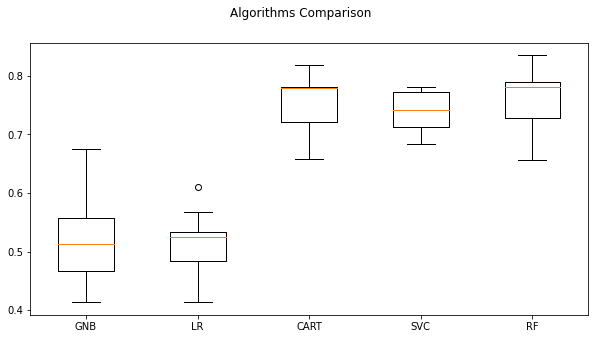

In [120]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

# Valutazione Inferance Rate medio (con cross validation)

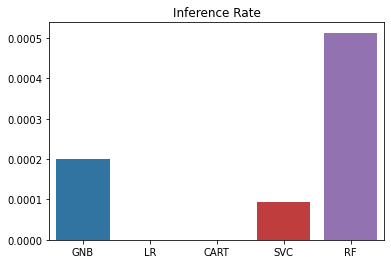

In [126]:
algorithms = []
names = []
for name, model in models:
    names.append(name)
plot_inference_time(names, runtimes_avg)

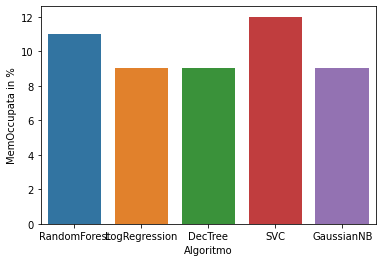

In [153]:
csv = read_csv("ModelComparison.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata'])
plt.ylabel("MemOccupata in %")
plt.show()

# Export Models in C code

In [146]:
modelsInPipeline = []
modelsInPipeline.append('LR')

In [147]:
for name, model in models:
    prepath = 'exportedModels/'
    path = prepath + name + '.h'
    if name in modelsInPipeline:
        model = model[1]
    with open(path, 'w') as f:
        f.write(port(model))